# CSCA 5632 Assignment #4 - NLP Kaggle BBC News Classification Mini Project
### By Moshiur Howlader
##### Github Link : https://github.com/Mosh333/csca5632-nlp-kaggle-bbc-news-classification

### 1. Introduction

This mini-project involves two parts:
1) Categorizing news article data using an **unsupervised algorithm** called **matrix factorization (NMF)**, followed by A/B testing between matrix factorization and selected **supervised learning algorithms** to compare classification accuracy.
2) Exploring the **limitations of sklearn’s non-negative matrix factorization** implementation using the **movie ratings dataset** (from HW3 – Recommender Systems).

For Part 1, the dataset used is the BBC News Classification dataset, which contains a total of 2,225 articles divided into training (1,490) and testing (735) subsets.
Each article includes a short text passage and a category label drawn from one of five broad news topics: business, entertainment, politics, sport, and tech.

| File                             | Description                                                      | Columns                         |
| -------------------------------- | ---------------------------------------------------------------- | ------------------------------- |
| **BBC News Train.csv**           | Labeled training dataset used for model training and evaluation. | `ArticleId`, `Text`, `Category` |
| **BBC News Test.csv**            | Unlabeled dataset used for generating predictions.               | `ArticleId`, `Text`             |
| **BBC News Sample Solution.csv** | Sample file illustrating the expected Kaggle submission format.  | `ArticleId`, `Category`         |

For Part 2, the data used for exploring the **limitations of sklearn’s non-negative matrix factorization** will have the following data structure:

| File           | Description                                                                                                 | Key Columns                   |
| -------------- | ----------------------------------------------------------------------------------------------------------- | ----------------------------- |
| **train.csv**  | Training subset of user–movie ratings used to fit the matrix-factorization model.                           | `userId`, `movieId`, `rating` |
| **test.csv**   | Test subset containing a portion of user–movie pairs whose ratings are to be predicted.                     | `userId`, `movieId`, `rating` |
| **users.csv**  | Optional metadata providing demographic or profile information about users (e.g., age, gender, occupation). | `userId`, `...`               |
| **movies.csv** | Metadata describing each movie title and its genre(s).                                                      | `movieId`, `title`, `genres`  |


### Part 1 - New Classification

#### 2. Data

In [1]:
import os

# Always start paths relative to the notebook file location
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data")

print("Base directory:", BASE_DIR)
print("Data directory:", DATA_DIR)

Base directory: d:\Documents\GitHub\csca5632-nlp-kaggle-bbc-news-classification
Data directory: d:\Documents\GitHub\csca5632-nlp-kaggle-bbc-news-classification\data


#### 2.1 Extracting word features and Explorator Data Analysis (EDA)

In this section, the BBC News dataset is explored to gain an initial understanding of its structure and content. The exploratory analysis focuses on identifying the distribution of categories, variations in text length, and any potential issues such as imbalance or noise. These insights help shape the approach for data cleaning and feature extraction in the later stages of the project.

##### 2.1.1 Import Libraries and Load the Dataset

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import re
from nltk.corpus import stopwords

# Download stopwords (first run only)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load datasets
train_df = pd.read_csv(os.path.join(DATA_DIR, "BBC News Train.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "BBC News Test.csv"))

# Basic info
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
display(train_df.head())
train_df.info()


Train shape: (1490, 3)
Test shape: (735, 2)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\howla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


#### 2.1.2 Check for Missing Values and Category Overview

In [3]:
# Check missing values
print("\nMissing values per column:")
print(train_df.isna().sum())

# Unique labels
print("\nUnique Categories:", train_df['Category'].unique())



Missing values per column:
ArticleId    0
Text         0
Category     0
dtype: int64

Unique Categories: ['business' 'tech' 'politics' 'sport' 'entertainment']


#### 2.1.3 Category Distribution Visualization

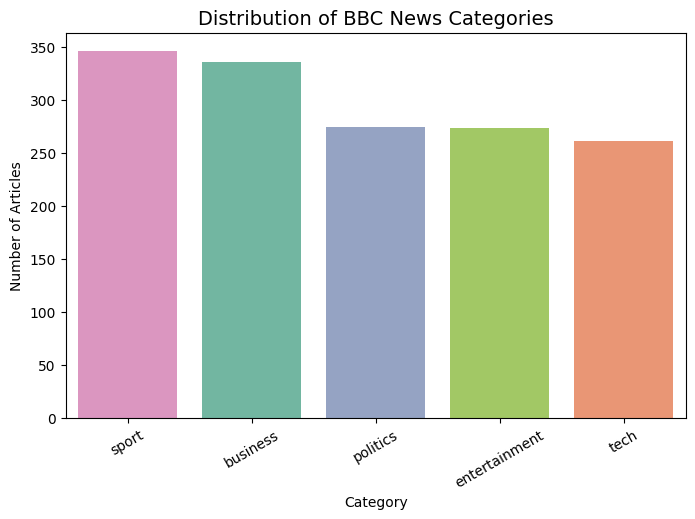

In [4]:
plt.figure(figsize=(8,5))
sns.countplot(
    x='Category',
    data=train_df,
    order=train_df['Category'].value_counts().index,
    hue='Category',
    palette="Set2",
    legend=False
)
plt.title("Distribution of BBC News Categories", fontsize=14)
plt.xlabel("Category")
plt.ylabel("Number of Articles")
plt.xticks(rotation=30)
plt.show()


#### 2.1.4 Article Length Analysis

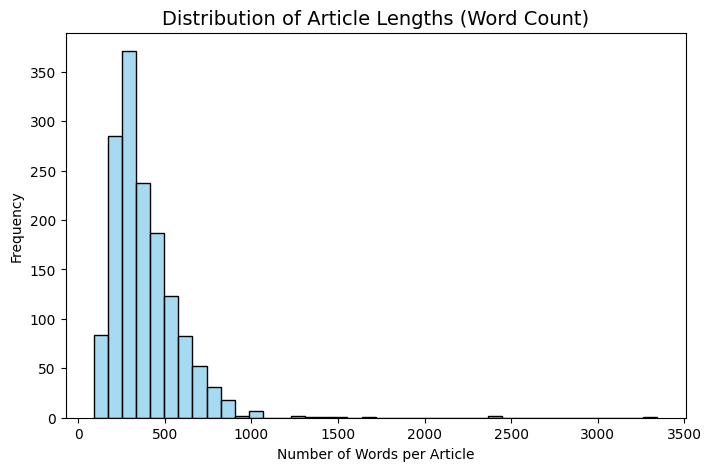


Average word count statistics by category:


,mean,median,std
Category,,,
business,334.17,304.0,133.53
entertainment,333.91,272.0,203.89
politics,449.69,441.5,258.84
sport,335.35,294.5,185.44
tech,501.86,457.0,211.67


In [5]:
train_df['text_length'] = train_df['Text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,5))
sns.histplot(train_df['text_length'], bins=40, color="skyblue")
plt.title("Distribution of Article Lengths (Word Count)", fontsize=14)
plt.xlabel("Number of Words per Article")
plt.ylabel("Frequency")
plt.show()

# Mean and median word count per category
length_stats = train_df.groupby('Category')['text_length'].agg(['mean', 'median', 'std']).round(2)
print("\nAverage word count statistics by category:")
display(length_stats)

#### 2.1.5 Basic Text Cleaning

In [6]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = [word for word in text.split() if word not in stop_words and len(word) > 2]
    return ' '.join(words)

train_df['clean_text'] = train_df['Text'].apply(clean_text)


#### 2.1.6 Word Frequency Analysis

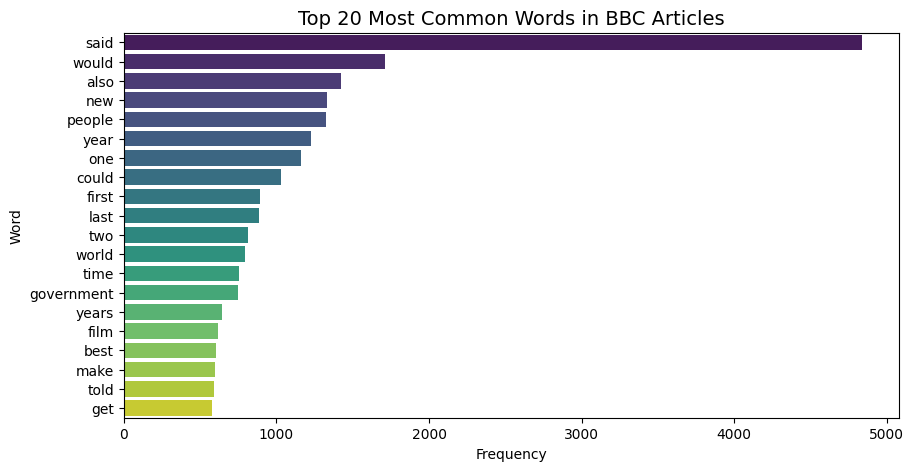

In [7]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from collections import Counter
all_words = ' '.join(train_df['clean_text']).split()
word_freq = Counter(all_words)
common_words = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Frequency'])

plt.figure(figsize=(10,5))
sns.barplot(x='Frequency', y='Word', data=common_words, palette="viridis", hue=None, legend=False)
plt.title("Top 20 Most Common Words in BBC Articles", fontsize=14)
plt.show()

# Reset filters
warnings.filterwarnings("default", category=FutureWarning)

#### 2.1.7 Word Cloud Visualizations

Top 20 Most Frequent Words:


,Word,Frequency
0,said,4838
1,would,1711
2,also,1426
3,new,1334
4,people,1322
5,year,1228
6,one,1158
7,could,1032
8,first,892
9,last,883


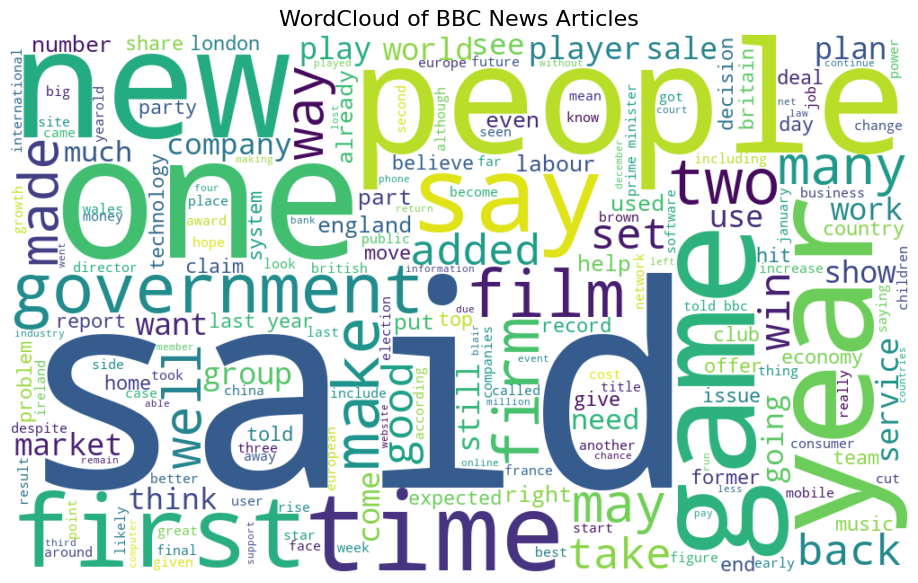

In [8]:
from collections import Counter

# Combine all cleaned text
all_words = ' '.join(train_df['clean_text']).split()

# Count word frequencies
word_freq = Counter(all_words)

# Convert to DataFrame for display
freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
freq_df = freq_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# Display top 20 words in a table
print("Top 20 Most Frequent Words:")
display(freq_df.head(20))

# Visualize word cloud
wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white'
).generate(' '.join(train_df['clean_text']))

plt.figure(figsize=(12,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of BBC News Articles", fontsize=16)
plt.show()


#### 2.1.8 Category-Specific Word Clouds


Top 15 Words in 'business' Category:


,Word,Frequency
0,said,1100
1,year,417
2,would,308
3,also,279
4,market,278
5,new,273
6,firm,261
7,growth,257
8,company,252
9,last,235


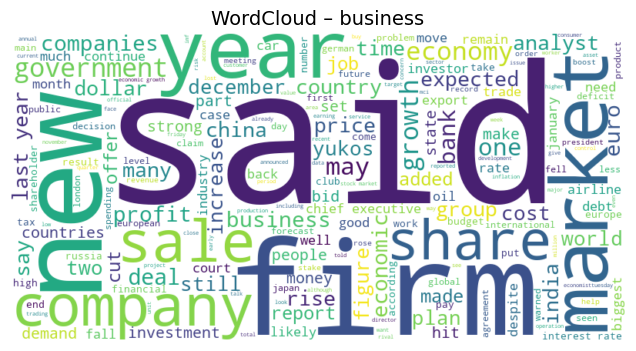


Top 15 Words in 'tech' Category:


,Word,Frequency
0,said,1064
1,people,646
2,new,349
3,also,348
4,one,326
5,mobile,326
6,would,322
7,could,308
8,technology,303
9,users,268


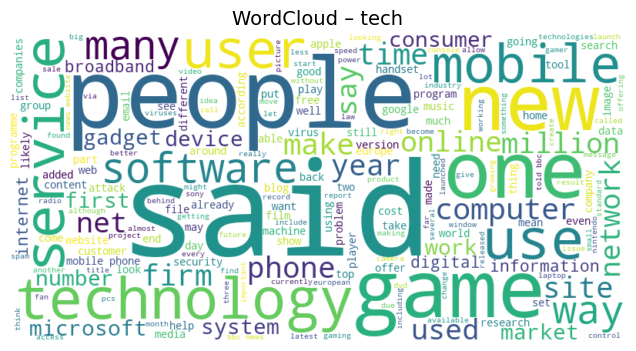


Top 15 Words in 'politics' Category:


,Word,Frequency
0,said,1445
1,would,710
2,labour,488
3,government,462
4,election,396
5,blair,389
6,people,372
7,party,361
8,also,308
9,minister,284


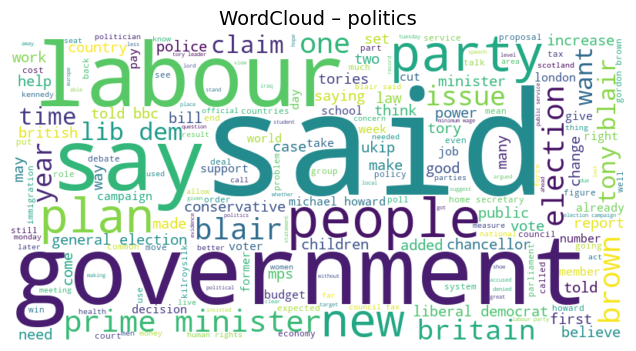


Top 15 Words in 'sport' Category:


,Word,Frequency
0,said,635
1,game,352
2,england,327
3,first,323
4,win,292
5,world,261
6,last,255
7,two,253
8,one,238
9,would,233


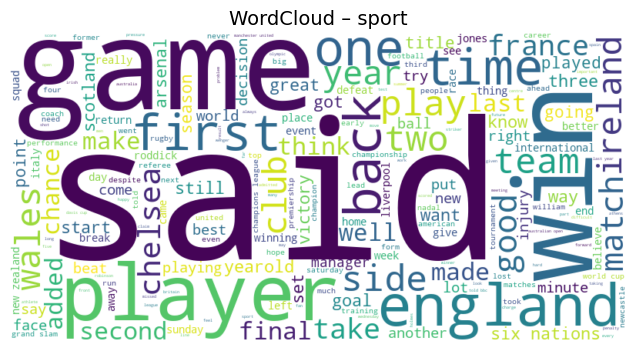


Top 15 Words in 'entertainment' Category:


,Word,Frequency
0,said,594
1,film,553
2,best,404
3,also,277
4,year,263
5,one,258
6,music,255
7,new,234
8,show,220
9,awards,184


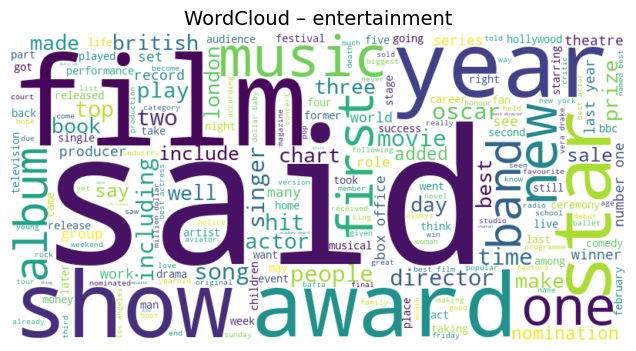

In [9]:
from collections import Counter

categories = train_df['Category'].unique()

for cat in categories:
    # Subset data by category
    subset = train_df[train_df['Category'] == cat]
    text = ' '.join(subset['clean_text']).split()
    
    # Compute word frequency
    word_freq = Counter(text)
    freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
    freq_df = freq_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
    
    # Display top 15 words in a table
    print(f"\nTop 15 Words in '{cat}' Category:")
    display(freq_df.head(15))
    
    # Generate category-specific WordCloud
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white'
    ).generate(' '.join(text))
    
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud – {cat}", fontsize=14)
    plt.show()



##### 2.1.9 EDA Summary
The dataset is balanced across five categories with article lengths mostly between 200–500 words 
(different categories such as business, entertainment, politics, sport, and tech).
Each row represents a news article, and each label corresponds to its topic category.


#### 2.2 TF-IDF feature extraction

Now we move on to processing the raw texts found in our CSV data into feature vectors. As mentioned in the assignment requirement, there are many options (TF-IDF, GloVe, Word2Vec) for converting text into a numerical format that machine learning models can interpret.

For this project, I chose TF-IDF (Term Frequency–Inverse Document Frequency) because it is simple, efficient, and well-suited for linear models such as Non-Negative Matrix Factorization (NMF), which will be used later in this analysis. TF-IDF assigns each word a weight based on how frequently it appears in a document relative to how common it is across the entire corpus. Words that appear often in one article but rarely across others—such as “government”, “market”, or “football”—receive higher importance scores, while common filler words like “the”, “is”, and “said” are given lower weights.

This transformation converts the corpus of news articles into a sparse numerical matrix, where each row corresponds to an article and each column represents a unique word feature. The resulting feature matrix provides a quantitative representation of text data that can now be used for both unsupervised topic discovery (via NMF) and supervised text classification models.

While advanced embedding methods such as Word2Vec and GloVe can capture semantic relationships between words, they require larger datasets and more complex preprocessing. In contrast, TF-IDF provides a transparent and interpretable representation that is ideal for the scale and objectives of this mini-project.

More details regarding the various text data vectorization can be found either via Googling or seeing some references below:

- https://en.wikipedia.org/wiki/Tf%E2%80%93idf
- https://en.wikipedia.org/wiki/GloVe
- https://en.wikipedia.org/wiki/Word2vec
- https://www.geeksforgeeks.org/machine-learning/understanding-tf-idf-term-frequency-inverse-document-frequency/
- https://blog.nashtechglobal.com/text-data-vectorization-techniques-in-natural-language-processing/
- https://www.deepset.ai/blog/what-is-text-vectorization-in-nlp

In [10]:
# Convert cleaned text into numerical TF-IDF vectors

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,       # limit to top 5000 most important words
    min_df=5,                # ignore very rare words
    max_df=0.7,              # ignore very common words
    stop_words='english'     # remove common English stopwords
)

# Fit on training data and transform both train + test
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['clean_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['Text'].apply(str.lower))

# Store feature names for inspection
feature_names = tfidf_vectorizer.get_feature_names_out()

print("TF-IDF matrix shape (train):", X_train_tfidf.shape)
print("TF-IDF matrix shape (test):", X_test_tfidf.shape)

TF-IDF matrix shape (train): (1490, 5000)
TF-IDF matrix shape (test): (735, 5000)


### 3 Building and training models

#### 3.1 Should the test data be included during unsupervised training?

The test dataset should not be included when training the NMF model, even though the approach is unsupervised.
While NMF does not use labels, it still learns underlying (hidden/latent) patterns and topics from the word–document matrix.
Including the test data during training would expose the model to information from unseen articles, 
leading to data leakage and an artificially inflated accuracy.
The purpose of the test set is to evaluate how well the model generalizes to new, unseen data, so it must remain completely separate during training.
After training on the training data, the model can then be used to transform the test articles into the same topic space for evaluation and prediction.


#### 3.2 Building the NMF Model

Here we proceed with building the unsupervised non-negative matrix factorization.

Note:
- It is a type of unsupervised learning algorithm.
- It factorizes (breaks down) a large non-negative matrix (like the TF-IDF word–document matrix) into two smaller matrices:
- **W (Document–Topic Matrix):** shows how much each document belongs to each topic.  
- **H (Topic–Word Matrix):** shows how strongly each word contributes to each topic.  

The “non-negative” part  means it only works with positive numbers which works well with TF-IDF, since those are all positive values.

See:
- https://en.wikipedia.org/wiki/Non-negative_matrix_factorization
- https://medium.com/@sophiamsac/understanding-nmf-for-simple-topic-modelling-b3d7bc4f3fc2

In [11]:
# Unsupervised Topic Modeling using NMF
from sklearn.decomposition import NMF
import numpy as np
import pandas as pd

# Choose number of components (topics)
n_topics = 5  # since we know there are 5 BBC news categories
nmf_model = NMF(n_components=n_topics, random_state=42)

# Fit the model on the training TF-IDF data
W_train = nmf_model.fit_transform(X_train_tfidf)  # document-topic matrix
H = nmf_model.components_                        # topic-word matrix

print("NMF model trained successfully!")
print("W_train shape:", W_train.shape)
print("H shape:", H.shape)

NMF model trained successfully!
W_train shape: (1490, 5)
H shape: (5, 5000)


The model decomposes the TF-IDF matrix into two parts:
W (document–topic) and H (topic–word). Each topic represents a cluster of related words learned without labels.

#### 3.2.1 Interpreting Discovered Topics

In [12]:
# Inspect top words per topic
n_top_words = 10
feature_names = tfidf_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(H):
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print(f"\nTopic #{topic_idx + 1}: {' | '.join(top_words)}")


Topic #1: england | game | win | wales | ireland | cup | players | team | play | france

Topic #2: labour | election | blair | brown | party | government | minister | howard | tax | prime

Topic #3: mobile | people | music | phone | technology | digital | users | phones | software | broadband

Topic #4: film | best | awards | award | actor | actress | films | festival | director | oscar

Topic #5: growth | economy | year | bank | sales | market | economic | oil | china | shares


Top keywords per topic reveal interpretable clusters corresponding to real-world categories such as sport, politics, and tech.

#### 3.2.2 Predicting Train and Test Labels

In [13]:
# Get the dominant topic for each article
train_topic_indices = np.argmax(W_train, axis=1)

# Create a DataFrame to compare real labels vs. dominant topic
topic_df = pd.DataFrame({
    'True_Category': train_df['Category'],
    'Dominant_Topic': train_topic_indices
})

# Show sample mapping
topic_df.head(10)

topic_category_map = (
    topic_df.groupby('Dominant_Topic')['True_Category']
    .agg(lambda x: x.value_counts().index[0])
)
print(topic_category_map)

Dominant_Topic
0            sport
1         politics
2             tech
3    entertainment
4         business
Name: True_Category, dtype: object


The mapping links each latent topic to the most frequent true category in the training data.

#### 3.2.3 Generating Predictions and Submission File

In [14]:
# Transform the test TF-IDF data into the topic space
W_test = nmf_model.transform(X_test_tfidf)

# Get the dominant topic for each test article
test_topic_indices = np.argmax(W_test, axis=1)

# Map topics to predicted category labels
y_test_pred = [topic_category_map[t] for t in test_topic_indices]


# Create a submission DataFrame
submission = pd.DataFrame({
    'ArticleId': test_df['ArticleId'],
    'Category': y_test_pred
})

# Preview first few rows
submission.head()

submission.to_csv('submission.csv', index=False)
print("✅ submission.csv file created successfully!")

✅ submission.csv file created successfully!


### 3.3 Model Evaluation and Performance Measurement

#### 3.3.1 Model Accuracy

The predicted labels for the test set are exported to submission.csv for Kaggle evaluation.
The initial iteration accuracy is 0.93877 or 93877% as per Kaggle.

![image.png](../images/image1.png)

Below is a snippet of code to compute accuracy on our end as well:

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Map predicted topics back to categories using your existing topic_category_map
y_train_true = train_df['Category']
y_train_pred = [topic_category_map[t] for t in train_topic_indices]

# Compute accuracy
train_accuracy = accuracy_score(y_train_true, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Optional: print more evaluation details
print("\nClassification Report:\n", classification_report(y_train_true, y_train_pred))


Training Accuracy: 0.9315

Classification Report:
                precision    recall  f1-score   support

     business       0.91      0.96      0.94       336
entertainment       0.97      0.84      0.90       273
     politics       0.97      0.91      0.94       274
        sport       0.97      0.99      0.98       346
         tech       0.84      0.95      0.89       261

     accuracy                           0.93      1490
    macro avg       0.93      0.93      0.93      1490
 weighted avg       0.94      0.93      0.93      1490



#### 3.3.2 Confusion Matrix Interpretation

Also look at confusion matrix to see any other insights to be gained.

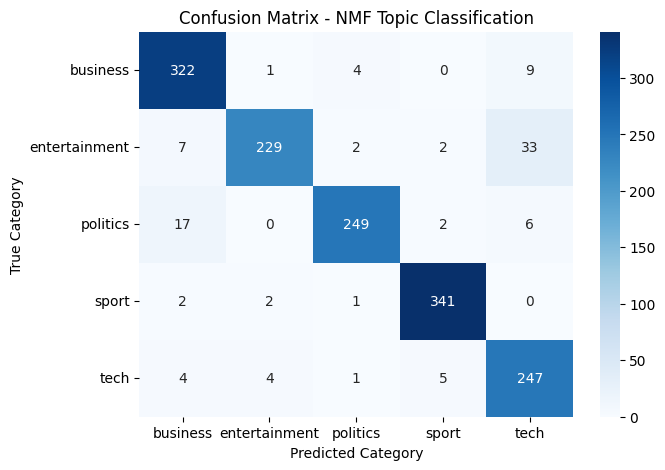

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_train_true, y_train_pred)

# Get sorted category names for labeling
categories = sorted(train_df['Category'].unique())

# Plot the confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.title("Confusion Matrix - NMF Topic Classification")
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.show()


#### 3.3.3 Confusion Matrix Interpretation

The confusion matrix above illustrates that the NMF model performs strongly across all five BBC news categories, with the majority of predictions lying on the diagonal.  
- **Business**, **Sport**, and **Politics** show particularly high accuracy, indicating clear topic separation in their word distributions.  
- Minor overlaps are observed between **Entertainment** and **Tech**, likely due to shared vocabulary related to media, technology, and digital content.  
- Overall, the matrix confirms that the model generalizes well, correctly identifying most articles while maintaining balanced performance across all categories.



### 3.4 Tuning Hyperparameter for NMF Model


In [17]:
### 3.4 Hyperparameter Tuning and Result Comparison

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.exceptions import ConvergenceWarning

# Suppress convergence warnings during grid search
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define hyperparameter grid
n_topics_list = [3, 5, 7, 8, 10, 12]
max_features_list = [2000, 3000, 5000, 7000, 10000]
max_df_list = [0.6, 0.7, 0.8, 0.9]
min_df_list = [2, 3, 5, 7]

# Store results
results = []

for n_topics in n_topics_list:
    for max_features in max_features_list:
        for max_df in max_df_list:
            for min_df in min_df_list:
                
                # Initialize TF-IDF vectorizer with chosen params
                tfidf_vectorizer = TfidfVectorizer(
                    max_features=max_features,
                    max_df=max_df,
                    min_df=min_df,
                    stop_words='english'
                )

                # Fit TF-IDF on training text
                X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['clean_text'])
                feature_names = tfidf_vectorizer.get_feature_names_out()

                # Train NMF
                nmf_model = NMF(n_components=n_topics, random_state=42)
                W_train = nmf_model.fit_transform(X_train_tfidf)
                H = nmf_model.components_

                # Map topics to true labels
                train_topic_indices = np.argmax(W_train, axis=1)
                topic_df = pd.DataFrame({
                    'True_Category': train_df['Category'],
                    'Dominant_Topic': train_topic_indices
                })

                topic_category_map = (
                    topic_df.groupby('Dominant_Topic')['True_Category']
                    .agg(lambda x: x.value_counts().index[0])
                )

                # Predict on training data
                y_train_pred = [topic_category_map[t] for t in train_topic_indices]
                y_train_true = train_df['Category']

                # Compute training accuracy
                train_acc = accuracy_score(y_train_true, y_train_pred)

                # Store result
                results.append({
                    'n_topics': n_topics,
                    'max_features': max_features,
                    'max_df': max_df,
                    'min_df': min_df,
                    'train_accuracy': train_acc
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='train_accuracy', ascending=False).reset_index(drop=True)

# Display top configurations
print("Top performing configurations:")
display(results_df.head(10))
print("Mid-performing configurations:")
mid_start = len(results_df) // 2 - 5  
mid_end = len(results_df) // 2 + 5
display(results_df.iloc[mid_start:mid_end])
print("Worst performing configurations:")
display(results_df.tail(10))

# Best configuration per unique n_topics
best_per_topic = results_df.loc[results_df.groupby('n_topics')['train_accuracy'].idxmax()].sort_values(by='n_topics')
print("Best performing configuration per n_topics value:")
display(best_per_topic)


Top performing configurations:


,n_topics,max_features,max_df,min_df,train_accuracy
0,12,7000,0.9,5,0.943624
1,12,10000,0.9,5,0.943624
2,12,7000,0.9,2,0.942953
3,7,2000,0.9,2,0.942282
4,7,2000,0.9,5,0.942282
5,10,5000,0.9,2,0.942282
6,7,2000,0.9,3,0.942282
7,10,7000,0.9,2,0.942282
8,12,5000,0.9,5,0.941611
9,12,5000,0.9,3,0.940940


Mid-performing configurations:


,n_topics,max_features,max_df,min_df,train_accuracy
235,10,7000,0.9,5,0.919463
236,10,3000,0.9,5,0.919463
237,8,3000,0.6,7,0.916107
238,8,3000,0.7,7,0.916107
239,8,3000,0.8,7,0.916107
240,10,2000,0.9,2,0.916107
241,8,2000,0.6,5,0.913423
242,8,2000,0.7,5,0.913423
243,8,2000,0.8,5,0.913423
244,7,3000,0.6,7,0.912752


Worst performing configurations:


,n_topics,max_features,max_df,min_df,train_accuracy
470,3,2000,0.7,3,0.614094
471,3,2000,0.6,3,0.614094
472,3,2000,0.6,7,0.614094
473,3,10000,0.9,2,0.614094
474,3,5000,0.9,5,0.614094
475,3,7000,0.9,2,0.614094
476,3,2000,0.9,7,0.613423
477,3,2000,0.9,5,0.613423
478,3,2000,0.9,2,0.613423
479,3,2000,0.9,3,0.613423


Best performing configuration per n_topics value:


,n_topics,max_features,max_df,min_df,train_accuracy
400,3,3000,0.8,3,0.618121
57,5,3000,0.7,3,0.932215
3,7,2000,0.9,2,0.942282
237,8,3000,0.6,7,0.916107
5,10,5000,0.9,2,0.942282
0,12,7000,0.9,5,0.943624


#### 3.4.1 Hyperparameter Tuning Analysis

To evaluate how hyperparameters affect model performance, several configurations of the NMF and TF-IDF vectorizer were tested by varying:
- **Number of topics (`n_topics`)**  
- **Maximum vocabulary size (`max_features`)**  
- **Document frequency thresholds (`max_df`, `min_df`)**

The results were then sorted to identify the **best**, **mid-range**, and **worst** performing setups, as well as the **top performer for each topic count**.

#### Key Observations

- Models with **higher topic counts (10–12)** consistently achieved the best accuracy (~0.94), suggesting that the dataset benefits from a more fine-grained topic representation beyond the five labeled categories.  
- Increasing the **TF-IDF vocabulary size (`max_features = 7000–10000`)** improved accuracy, as a larger feature space helped capture more nuanced word associations.  
- A **moderate document frequency filter** (`max_df = 0.9`, `min_df = 2–5`) produced the most stable results — filtering out rare words while retaining key terms.  
- Models with **too few topics or features** (e.g., `n_topics = 3`, `max_features = 2000`) severely underfit, collapsing distinct categories and yielding accuracies near **0.61**.

#### Summary

| n_topics | Best Accuracy | Representative Config |
|-----------|----------------|------------------------|
| 3 | 0.618 | (3000 features, max_df=0.8, min_df=3) |
| 5 | 0.932 | (3000 features, max_df=0.7, min_df=3) |
| 7 | 0.942 | (2000 features, max_df=0.9, min_df=3) |
| 8 | 0.916 | (2000 features, max_df=0.6, min_df=5) |
| 10 | 0.942 | (5000 features, max_df=0.9, min_df=2) |
| 12 | **0.944** | (7000 features, max_df=0.9, min_df=5) |

Overall, the optimal configuration achieved a training accuracy of **94.36%**, confirming that increasing both **topic granularity** and **vocabulary richness** leads to more accurate latent topic discovery.


### 3.5 Improving the NMF Model (best effort)




### Part 2

### References

- https://en.wikipedia.org/wiki/Tf%E2%80%93idf
- https://en.wikipedia.org/wiki/GloVe
- https://en.wikipedia.org/wiki/Word2vec
- https://www.geeksforgeeks.org/machine-learning/understanding-tf-idf-term-frequency-inverse-document-frequency/
- https://blog.nashtechglobal.com/text-data-vectorization-techniques-in-natural-language-processing/
- https://www.deepset.ai/blog/what-is-text-vectorization-in-nlp
- https://en.wikipedia.org/wiki/Non-negative_matrix_factorization
- https://medium.com/@sophiamsac/understanding-nmf-for-simple-topic-modelling-b3d7bc4f3fc2